# Late Fusion Aggregators

### Take Classifications and Try Multiple Aggregate Functions

Two models:
1. Average of Individual classifiers
2. Average ranking (ignores "model confidence")
3. Weighted Average (weighted by AUC of each class, scaled between 0 and 1)
4. Decision tree embedder (explainable - can also retrieve for each data point which values were important (for classifications, human explainable, for embeddings, perhaps add up % of image/notes/tab features used in decision)

Benefits of Late Fusion:
Good with missing data!!! (Huge for product side - multiple fusion models to handle different use cases)

In [2]:
import json

import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, hamming_loss, multilabel_confusion_matrix
from sklearn.preprocessing import LabelBinarizer

from sklearn import svm

from sklearn.metrics import roc_curve, auc, roc_auc_score

import seaborn as sn
import matplotlib.pyplot as plt

In [11]:
#load data
combined_train_df = pd.read_pickle(r'../data/s3/fusion_data/combined_train_df_all_embeddings_classifications.pkl')
combined_val_df = pd.read_pickle(r'../data/s3/fusion_data/combined_val_df_all_embeddings_classifications.pkl')
combined_test_df = pd.read_pickle(r'../data/s3/fusion_data/combined_test_df_all_embeddings_classifications.pkl')

In [15]:
combined_train_df.columns

Index(['index', 'patient_id', 'visit_id', 'study_id', 'temperature',
       'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity',
       'positive_label_total', 'finding_names', 'radiology_note',
       'discharge_note', 'chief_complaint',
       'major_surgical_or_invasive_procedure', 'history_of_present_illness',
       'past_medical_history', 'family_history', 'atelectasis', 'cardiomegaly',
       'lung_opacity', 'pleural_effusion', 'dataset_type', 'dicom_id',
       'notes_classifications', 'notes_embeddings', 'notes_hidden_embeddings',
       'img_classifications', 'img_embeddings', 'img_densefeatures',
       'tabular_classifications0', 'tabular_classifications1',
       'tabular_classifications2', 'tabular_classifications3',
       'tabular_classifications4', 'notes_classifications0',
       'notes_classifications1', 'notes_classifications2',
       'notes_classifications3', 'notes_classifications4',
       'img_classifications0', 'img_classifications1', 'img_classif

In [33]:
#create aggregated embeddings datasets
#loading datasets
train_classes_df = combined_train_df[['patient_id', 'finding_names', 'tabular_classifications0', 'tabular_classifications1',
                                      'tabular_classifications2', 'tabular_classifications3', 'tabular_classifications4', 
                                      'notes_classifications0', 'notes_classifications1', 'notes_classifications2', 
                                      'notes_classifications3', 'notes_classifications4', 'img_classifications0', 
                                      'img_classifications1', 'img_classifications2', 'img_classifications3', 
                                      'img_classifications4']]  

val_classes_df = combined_val_df[['patient_id', 'finding_names', 'tabular_classifications0', 'tabular_classifications1',
                                      'tabular_classifications2', 'tabular_classifications3', 'tabular_classifications4', 
                                      'notes_classifications0', 'notes_classifications1', 'notes_classifications2', 
                                      'notes_classifications3', 'notes_classifications4', 'img_classifications0', 
                                      'img_classifications1', 'img_classifications2', 'img_classifications3', 
                                      'img_classifications4']] 

test_classes_df = combined_test_df[['patient_id', 'finding_names', 'tabular_classifications0', 'tabular_classifications1',
                                      'tabular_classifications2', 'tabular_classifications3', 'tabular_classifications4', 
                                      'notes_classifications0', 'notes_classifications1', 'notes_classifications2', 
                                      'notes_classifications3', 'notes_classifications4', 'img_classifications0', 
                                      'img_classifications1', 'img_classifications2', 'img_classifications3', 
                                      'img_classifications4']]

In [34]:
train_classes_df.head()

,patient_id,finding_names,tabular_classifications0,tabular_classifications1,tabular_classifications2,tabular_classifications3,tabular_classifications4,notes_classifications0,notes_classifications1,notes_classifications2,notes_classifications3,notes_classifications4,img_classifications0,img_classifications1,img_classifications2,img_classifications3,img_classifications4
0,11388716,atelectasis,0.208681,0.158534,0.110880,0.248646,0.273259,0.122906,0.306664,0.049760,0.397685,0.122985,0.002679,0.986562,0.001635,0.008502,0.000622
1,11539363,atelectasis,0.312157,0.195341,0.144800,0.174402,0.173300,0.474254,0.192949,0.216597,0.081928,0.034271,0.085059,0.906197,0.004783,0.003748,0.000213
2,10833304,atelectasis,0.396899,0.157088,0.163143,0.136013,0.146858,0.461573,0.215725,0.161198,0.123959,0.037544,0.002391,0.997314,0.000177,0.000105,0.000012
3,19849119,atelectasis,0.290064,0.176080,0.165073,0.162788,0.205994,0.232690,0.496566,0.054956,0.093965,0.121823,0.000162,0.999696,0.000022,0.000053,0.000067
4,11749991,atelectasis,0.413125,0.163641,0.124322,0.176546,0.122366,0.271716,0.461655,0.045886,0.163782,0.056961,0.002136,0.997198,0.000164,0.000160,0.000342


## Average Classification

In [7]:
#working locally - generate 3 random numpy arrays of length 5
tabular_output = np.random.dirichlet(np.ones(5),size=1)
notes_output = np.random.dirichlet(np.ones(5),size=1)
img_output = np.random.dirichlet(np.ones(5),size=1)

print(f'Tabular output is: {tabular_output}')
print(f'Notes output is: {notes_output}')
print(f'Images output is: {img_output}')

Tabular output is: [[0.5890666  0.09106082 0.2182225  0.06412911 0.03752096]]
Notes output is: [[0.04360646 0.41304847 0.41826189 0.0643386  0.06074458]]
Images output is: [[0.7903777  0.00734957 0.08417887 0.00951822 0.10857564]]


In [22]:
def late_fusion_avg(output1 = None, output2 = None, output3 = None):
    '''Aggregates findings by averaging the class level softmax scores'''
    if not isinstance(output1, np.ndarray) or not isinstance(output2, np.ndarray) or not isinstance(output3, np.ndarray):
        #only two data outputs given
        if not isinstance(output3, np.ndarray) and isinstance(output1, np.ndarray) and isinstance(output2, np.ndarray):
            outputs = np.concatenate((output1, output2))
            late_fusion_output = np.mean(outputs, axis = 0)
        #only one data output given
        #optional: change this to give the output of the individual model
        elif not isinstance(output3, np.ndarray) and not isinstance(output2, np.ndarray) and isinstance(output1, np.ndarray):
            late_fusion_output = "This is not a fusion model! Please see the individual model results corresponding to the data type you entered above."
        #no outputs given
        else:
            late_fusion_output = "No models were run! Please inpupt multiple data types and run models to see a fusion result."
    else:
        outputs = np.concatenate((output1, output2, output3))
        late_fusion_output = np.mean(outputs, axis = 0)
            
    return late_fusion_output

In [24]:
#test cases
print(f'The full late fusion average output is: {late_fusion_avg(tabular_output, notes_output, img_output)}')
print(f'The full late fusion average output is: {late_fusion_avg(tabular_output, notes_output)}')
print(f'The full late fusion average output is: {late_fusion_avg(tabular_output, img_output)}')
print(f'The full late fusion average output is: {late_fusion_avg(notes_output, img_output)}')
print(f'The full late fusion average output is: {late_fusion_avg(tabular_output)}')
print(f'The full late fusion average output is: {late_fusion_avg(notes_output)}')
print(f'The full late fusion average output is: {late_fusion_avg(img_output)}')
print(f'The full late fusion average output is: {late_fusion_avg()}')

The full late fusion average output is: [0.47435025 0.17048629 0.24022109 0.04599531 0.06894706]
The full late fusion average output is: [0.31633653 0.25205465 0.3182422  0.06423386 0.04913277]
The full late fusion average output is: [0.68972215 0.0492052  0.15120069 0.03682366 0.0730483 ]
The full late fusion average output is: [0.41699208 0.21019902 0.25122038 0.03692841 0.08466011]
The full late fusion average output is: This is not a fusion model! Please see the individual model results corresponding to the data type you entered above.
The full late fusion average output is: This is not a fusion model! Please see the individual model results corresponding to the data type you entered above.
The full late fusion average output is: This is not a fusion model! Please see the individual model results corresponding to the data type you entered above.
The full late fusion average output is: No models were run! Please inpupt multiple data types and run models to see a fusion result.


## Check metrics for average aggregator

In [59]:
# print classification report 
print(classification_report(y_val, grid_predictions)) 

              precision    recall  f1-score   support

         0.0       0.86      0.63      0.73      1376
         1.0       0.12      0.21      0.15       117
         2.0       0.30      0.45      0.36       128
         3.0       0.28      0.46      0.35       219
         4.0       0.22      0.45      0.30        84

    accuracy                           0.56      1924
   macro avg       0.36      0.44      0.38      1924
weighted avg       0.68      0.56      0.61      1924



In [121]:
print(confusion_matrix(y_val.numpy(), grid_predictions))

array([[867, 137, 102, 190,  80],
       [ 48,  24,  18,  22,   5],
       [ 29,  12,  57,  16,  14],
       [ 55,  22,   9, 100,  33],
       [ 14,   5,   2,  25,  38]], dtype=int64)

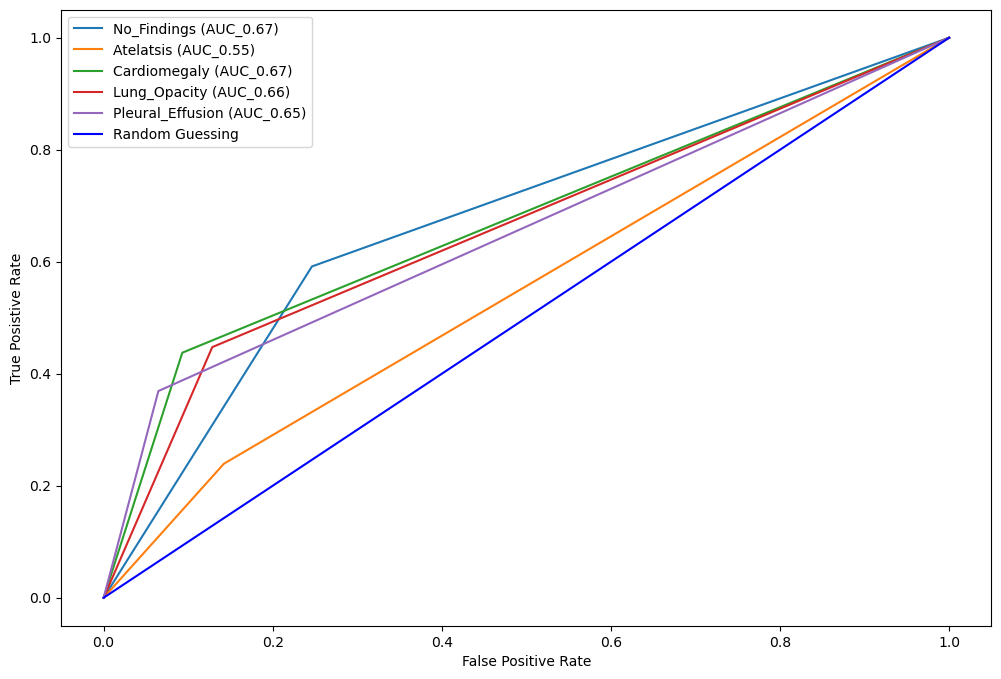

ROC AUC Score---------->
0.641


In [138]:
create_roc_auc_curve_others(clf, X_val, y_val)

# Average Ranking
Average the relative ranks together, rather than softmax values

In [31]:
#working locally - generate 3 random numpy arrays of length 5
tabular_output = np.random.dirichlet(np.ones(5),size=1)
notes_output = np.random.dirichlet(np.ones(5),size=1)
img_output = np.random.dirichlet(np.ones(5),size=1)

print(f'Tabular output is: {tabular_output}')
print(f'Notes output is: {notes_output}')
print(f'Images output is: {img_output}')

Tabular output is: [[0.20728265 0.1673775  0.28294073 0.29376171 0.04863741]]
Notes output is: [[0.21266583 0.03624181 0.02748612 0.54740161 0.17620462]]
Images output is: [[0.80610009 0.07074878 0.09833491 0.00469825 0.02011797]]


In [53]:
def late_fusion_avg_rank(output1 = None, output2 = None, output3 = None):
    '''Averages the relative rank of each class, should ignore "model confidence"'''
    
    if not isinstance(output1, np.ndarray) or not isinstance(output2, np.ndarray) or not isinstance(output3, np.ndarray):
        #only two data outputs given
        if not isinstance(output3, np.ndarray) and isinstance(output1, np.ndarray) and isinstance(output2, np.ndarray):
            rank1 = output1.argsort().argsort().reshape(output1.shape)
            rank2 = output2.argsort().argsort().reshape(output2.shape)
            
            outputs = np.concatenate((rank1, rank2))
            late_fusion_output = np.mean(outputs, axis = 0)
            
        #only one data output given
        elif not isinstance(output3, np.ndarray) and not isinstance(output2, np.ndarray) and isinstance(output1, np.ndarray):
            late_fusion_output = "This is not a fusion model! Please see the individual model results corresponding to the data type you entered above."
       
        #no outputs given
        else:
            late_fusion_output = "No models were run! Please inpupt multiple data types and run models to see a fusion result."
    else:
        rank1 = output1.argsort(-output1)
        rank2 = output2.argsort().argsort().reshape(output2.shape)
        rank3 = output3.argsort().argsort().reshape(output3.shape)

        outputs = np.concatenate((rank1, rank2, rank3))
        late_fusion_output = np.mean(outputs, axis = 0)
            
    return late_fusion_output

In [54]:
#test cases
print(f'The full late fusion average output is: {late_fusion_avg_rank(tabular_output, notes_output, img_output)}')
print(f'The full late fusion average output is: {late_fusion_avg_rank(tabular_output, notes_output)}')
print(f'The full late fusion average output is: {late_fusion_avg_rank(tabular_output, img_output)}')
print(f'The full late fusion average output is: {late_fusion_avg_rank(notes_output, img_output)}')
print(f'The full late fusion average output is: {late_fusion_avg_rank(tabular_output)}')
print(f'The full late fusion average output is: {late_fusion_avg_rank(notes_output)}')
print(f'The full late fusion average output is: {late_fusion_avg_rank(img_output)}')
print(f'The full late fusion average output is: {late_fusion_avg_rank()}')

The full late fusion average output is: [0.1        0.04444444 0.06666667 0.08888889 0.03333333]
The full late fusion average output is: [2.5 1.  1.5 4.  1. ]
The full late fusion average output is: [3.  1.5 3.  2.  0.5]
The full late fusion average output is: [3.5 1.5 1.5 2.  1.5]
The full late fusion average output is: This is not a fusion model! Please see the individual model results corresponding to the data type you entered above.
The full late fusion average output is: This is not a fusion model! Please see the individual model results corresponding to the data type you entered above.
The full late fusion average output is: This is not a fusion model! Please see the individual model results corresponding to the data type you entered above.
The full late fusion average output is: No models were run! Please inpupt multiple data types and run models to see a fusion result.


# Weighted Average aggregator
Weighted based on class-level AUC

In [27]:
#working locally - generate 3 random numpy arrays of length 5
tabular_output = np.random.dirichlet(np.ones(5),size=1)
notes_output = np.random.dirichlet(np.ones(5),size=1)
img_output = np.random.dirichlet(np.ones(5),size=1)

print(f'Tabular output is: {tabular_output}')
print(f'Notes output is: {notes_output}')
print(f'Images output is: {img_output}')

Tabular output is: [[0.06120404 0.04781931 0.02780818 0.66310534 0.20006313]]
Notes output is: [[0.55782557 0.14232564 0.01039623 0.1069354  0.18251716]]
Images output is: [[0.12965855 0.04102065 0.15604203 0.37740312 0.29587565]]


In [30]:
tabular_output.argmax()

3

In [ ]:
def late_fusion_weighted_avg(output1 = None, output2 = None, output3 = None):
    '''Weights each softmax value by the relative test-AUC for that class'''

    
    
    if not isinstance(output1, np.ndarray) or not isinstance(output2, np.ndarray) or not isinstance(output3, np.ndarray):
        #only two data outputs given
        if not isinstance(output3, np.ndarray) and isinstance(output1, np.ndarray) and isinstance(output2, np.ndarray):
            outputs = np.concatenate((output1, output2))
            late_fusion_output = np.mean(outputs, axis = 0)
        #only one data output given
        elif not isinstance(output3, np.ndarray) and not isinstance(output2, np.ndarray) and isinstance(output1, np.ndarray):
            late_fusion_output = "This is not a fusion model! Please see the individual model results corresponding to the data type you entered above."
        #no outputs given
        else:
            late_fusion_output = "No models were run! Please inpupt multiple data types and run models to see a fusion result."
    else:
        outcome1 = output1.argmax()
        outcome2 = output2.argmax()
        outcome3 = output3.argmax()
        
        outputs = np.concatenate((output1, output2, output3))
        late_fusion_output = np.mean(outputs, axis = 0)
            
    return late_fusion_output